### Pre-requisites

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install wandb -qU

In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
import os
import numpy as np
import torch
import time
import math
import sys
import copy
import datetime
import pickle
import errno
from tqdm import tqdm
from PIL import Image
import PIL.ImageOps  
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil
import cv2
import wandb
wandb.login()
# c390abcd434dcb1654d8e2597e93b0f775494b47

### Data

In [ ]:
class PuzzleDataset(object):
    def __init__(self, imgs1, imgs2, match_types, pair_types):
        self.root = '/content/gdrive/MyDrive/puzzle_pieces'
        self.imgs1 = imgs1
        self.imgs2 = imgs2
        if not torch.is_tensor(imgs1) and not torch.is_tensor(match_types):
          self.match_types = torch.from_numpy(match_types)
        if not torch.is_tensor(imgs1) and not torch.is_tensor(pair_types):
          self.pair_types = torch.from_numpy(pair_types)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
      return len(self.imgs1)

    def get_image(self, path):
      with open(os.path.abspath(path), 'rb') as f:
          with Image.open(f) as img:
              return img.convert('L') 

    def get_rotated_90(self, path):
      with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
          return img.convert('L').rotate(-90)

    def get_rotated_180(self, path):
      with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
          return img.convert('L').rotate(-180)

    def get_rotated_270(self, path):
      with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
          return img.convert('L').rotate(-270)      

    # def get_image_inv(self, path):
    #   with open(os.path.abspath(path), 'rb') as f:
    #       with Image.open(f) as img:
    #           return PIL.ImageOps.invert(img.convert('L'))

    # def get_rotated_90_inv(self, path):
    #   with open(os.path.abspath(path), 'rb') as f:
    #     with Image.open(f) as img:
    #       return PIL.ImageOps.invert(img.convert('L').rotate(-90))

    # def get_rotated_180_inv(self, path):
    #   with open(os.path.abspath(path), 'rb') as f:
    #     with Image.open(f) as img:
    #       return PIL.ImageOps.invert(img.convert('L').rotate(-180))

    # def get_rotated_270_inv(self, path):
    #   with open(os.path.abspath(path), 'rb') as f:
    #     with Image.open(f) as img:
    #       return PIL.ImageOps.invert(img.convert('L').rotate(-270))      
             
    def __getitem__(self, idx):
      path_to_images = os.path.join(self.root, f'masks_crop_tight')
      path_to_img1 = os.path.join(path_to_images, self.imgs1[idx])
      path_to_img2 = os.path.join(path_to_images, self.imgs2[idx])

      if self.pair_types[idx] == 1:
        img1 = self.get_rotated_90(path_to_img1)
        img2 = self.get_rotated_90(path_to_img2)
      elif self.pair_types[idx] == 3:
        img1 = self.get_rotated_270(path_to_img1)
        img2 = self.get_rotated_270(path_to_img2)
      elif self.pair_types[idx] == 4:
        img1 = self.get_rotated_180(path_to_img1)
        img2 = self.get_rotated_180(path_to_img2)
      elif self.pair_types[idx] == 2:
        img1 = self.get_image(path_to_img1)
        img2 = self.get_image(path_to_img2)
      else:
        img1 = self.get_image(path_to_img1)
        img2 = self.get_image(path_to_img2)
      
      img1 = self.transform(img1)
      _,w,h = img1.size()
      img1 = transforms.functional.crop(img1,0,int(w/2)+10,h,int(w/2)-10) # top, left, height, width

      img2 = self.transform(img2)
      _,w,h = img2.size()
      img2 = transforms.functional.crop(img2,0,0,h,int(w/2)-10)
      # print(path_to_img1, path_to_img2, self.pair_types[idx])
      return img1, img2, self.match_types[idx]


In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/puzzle_pieces/puzzle_pairs_train.csv')
val_df = pd.read_csv('/content/gdrive/MyDrive/puzzle_pieces/puzzle_pairs_val.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/puzzle_pieces/puzzle_pairs_test.csv')

In [ ]:
def get_img(data_df, col_img1, col_img2, col_match_type, col_pair_type):
  img1 = data_df[col_img1].astype('string').to_numpy()
  img2 = data_df[col_img2].astype('string').to_numpy()
  match_type = data_df[col_match_type].astype('float').to_numpy()
  pair_type = data_df[col_pair_type].astype('float').to_numpy()
  return img1, img2, match_type, pair_type

img1_train, img2_train, match_type_train, pair_type_train = get_img(train_df, 'img1_name', 'img2_name', 'match_type', 'pair_type')
img1_test, img2_test, match_type_test, pair_type_test = get_img(test_df, 'img1_name', 'img2_name', 'match_type', 'pair_type')
img1_val, img2_val, match_type_val, pair_type_val = get_img(val_df, 'img1_name', 'img2_name', 'match_type', 'pair_type')

In [ ]:
dataset_train = PuzzleDataset(img1_train, img2_train, match_type_train, pair_type_train)
dataset_test = PuzzleDataset(img1_test, img2_test, match_type_test, pair_type_test)
dataset_val = PuzzleDataset(img1_val, img2_val, match_type_val, pair_type_val)

dataloaders = {'train': torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=2),
               'val': torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=True, num_workers=2),
               'test': torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=True, num_workers=2)
              }
dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val), 'test': len(dataset_test)}

In [ ]:
print(dataset_sizes)

{'train': 2322, 'val': 664, 'test': 332}


1 ariel_60.png ariel_49.png 3 1


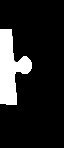

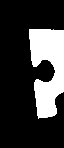

In [ ]:
imagine=dataset_test.__getitem__(6)
print(int(imagine[2]), test_df.loc[6][0], test_df.loc[6][1], test_df.loc[6][2], test_df.loc[6][3])
pil_image = torchvision.transforms.ToPILImage()(imagine[0])
pil_image.show()
pil_image = torchvision.transforms.ToPILImage()(imagine[1])
pil_image.show()

0 cinderella_44.png cinderella_33.png 0


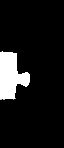

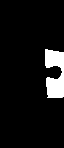

1 zana_41.png zana_56.png 1


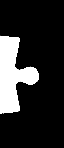

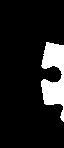

1 frozen_50.png frozen_51.png 4


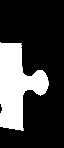

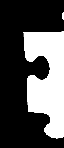

0 rapunzel_28.png rapunzel_20.png 0


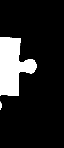

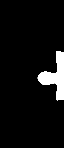

1 frozen_35.png frozen_26.png 3


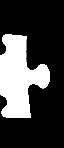

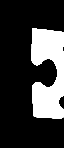

0 zana_62.png zana_38.png 0


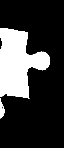

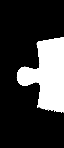

1 ariel_60.png ariel_49.png 3


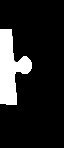

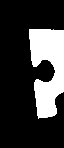

In [ ]:
for i in range(7):  
  img=dataset_test.__getitem__(i)
  print(int(img[2]), test_df.loc[i][0], test_df.loc[i][1], test_df.loc[i][2])
  pil_image = torchvision.transforms.ToPILImage()(img[0])
  pil_image.show()
  pil_image = torchvision.transforms.ToPILImage()(img[1])
  pil_image.show()

### Define Model

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11,stride=1),
            nn.Conv2d(64, 64, kernel_size=11,stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5,stride=1,padding=2),
            nn.Conv2d(128, 128, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128,256, kernel_size=3,stride=1,padding=1),
            nn.Conv2d(256,256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(20480 , 1024),
            nn.ReLU(inplace=True), 
            # nn.Dropout(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2),
            nn.Softmax(1)
        )    

    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output2 = self.cnn1(input2)
        # print(output1.size())
        
        output1 = abs(output1-output2) 
        output1 = output1.view(output1.size()[0], -1)
        output1 = self.fc1(output1)
        return output1

### Train Model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = -1
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for _, (inputs1, inputs2, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs1 = inputs1.to(device)
                inputs2 = inputs2.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs1, inputs2)
                    # labels = labels.reshape((labels.shape[0], 1))

                    # log_probs = F.log_softmax(outputs, dim=1)
                    # loss = F.nll_loss(log_probs, labels)

                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs1.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
              train_loss_history.append(float(epoch_loss))
            else:
              val_loss_history.append(float(epoch_loss))
            print(f'{phase} Loss: {epoch_loss:.4f} ')
            wandb.log({f'{phase} Epoch Loss': epoch_loss}, step=epoch) 

            # deep copy the model
            if phase == 'val' and (epoch_loss < best_loss or best_loss == -1):
                print(f'Best loss was changed from {best_loss} to', end=' ')
                best_loss = epoch_loss
                print(f'{best_loss}')
                best_model_wts = copy.deepcopy(model.state_dict())
                # torch.save(model, f"/content/gdrive/MyDrive/models/test.pt")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, train_loss_history, val_acc_history, val_loss_history 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
# print(model)

config_defaults = {
  'learning_rate': 0.0001, #1e-3
  'epochs': 30,
}

wandb.init(
   config=config_defaults,
   project="edge-match", 
   entity="disertatie",
   name=f"test-no-dropout"
)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=wandb.config.learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model, train_acc, train_loss, val_acc, val_loss = train_model(model, criterion, optimizer, exp_lr_scheduler, wandb.config.epochs)

Epoch 0/29
----------


100%|██████████| 37/37 [02:33<00:00,  4.16s/it]


train Loss: 0.6295 


100%|██████████| 11/11 [00:04<00:00,  2.57it/s]


val Loss: 0.5419 
Best loss was changed from -1 to 0.5418717107140875

Epoch 1/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.35it/s]


train Loss: 0.5374 


100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


val Loss: 0.5373 
Best loss was changed from 0.5418717107140875 to 0.5373194609061781

Epoch 2/29
----------


100%|██████████| 37/37 [00:28<00:00,  1.31it/s]


train Loss: 0.5160 


100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


val Loss: 0.5136 
Best loss was changed from 0.5373194609061781 to 0.5135763330631945

Epoch 3/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.5025 


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


val Loss: 0.5132 
Best loss was changed from 0.5135763330631945 to 0.5131590833146888

Epoch 4/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.5061 


100%|██████████| 11/11 [00:03<00:00,  3.09it/s]


val Loss: 0.5648 

Epoch 5/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.4908 


100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


val Loss: 0.5050 
Best loss was changed from 0.5131590833146888 to 0.5049695860908692

Epoch 6/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.4818 


100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


val Loss: 0.5451 

Epoch 7/29
----------


100%|██████████| 37/37 [00:28<00:00,  1.32it/s]


train Loss: 0.4612 


100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


val Loss: 0.4970 
Best loss was changed from 0.5049695860908692 to 0.4969839360340532

Epoch 8/29
----------


100%|██████████| 37/37 [00:28<00:00,  1.31it/s]


train Loss: 0.4514 


100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


val Loss: 0.4993 

Epoch 9/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


train Loss: 0.4525 


100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


val Loss: 0.4839 
Best loss was changed from 0.4969839360340532 to 0.48391134875366487

Epoch 10/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.36it/s]


train Loss: 0.4476 


100%|██████████| 11/11 [00:04<00:00,  2.67it/s]


val Loss: 0.5008 

Epoch 11/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.35it/s]


train Loss: 0.4440 


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


val Loss: 0.4950 

Epoch 12/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.35it/s]


train Loss: 0.4417 


100%|██████████| 11/11 [00:03<00:00,  3.06it/s]


val Loss: 0.4953 

Epoch 13/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


train Loss: 0.4436 


100%|██████████| 11/11 [00:03<00:00,  3.08it/s]


val Loss: 0.5224 

Epoch 14/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


train Loss: 0.4444 


100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


val Loss: 0.4865 

Epoch 15/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


train Loss: 0.4358 


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


val Loss: 0.4878 

Epoch 16/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.32it/s]


train Loss: 0.4350 


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


val Loss: 0.4887 

Epoch 17/29
----------


100%|██████████| 37/37 [00:28<00:00,  1.30it/s]


train Loss: 0.4352 


100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


val Loss: 0.4913 

Epoch 18/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.32it/s]


train Loss: 0.4344 


100%|██████████| 11/11 [00:03<00:00,  2.75it/s]


val Loss: 0.4924 

Epoch 19/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.4334 


100%|██████████| 11/11 [00:04<00:00,  2.46it/s]


val Loss: 0.4900 

Epoch 20/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.35it/s]


train Loss: 0.4332 


100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


val Loss: 0.4898 

Epoch 21/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.35it/s]


train Loss: 0.4334 


100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


val Loss: 0.4899 

Epoch 22/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.4331 


100%|██████████| 11/11 [00:03<00:00,  3.08it/s]


val Loss: 0.4921 

Epoch 23/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.4324 


100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


val Loss: 0.4902 

Epoch 24/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.4341 


100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


val Loss: 0.4905 

Epoch 25/29
----------


100%|██████████| 37/37 [00:28<00:00,  1.31it/s]


train Loss: 0.4323 


100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


val Loss: 0.4909 

Epoch 26/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.4340 


100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


val Loss: 0.4932 

Epoch 27/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.32it/s]


train Loss: 0.4322 


100%|██████████| 11/11 [00:03<00:00,  3.08it/s]


val Loss: 0.4910 

Epoch 28/29
----------


100%|██████████| 37/37 [00:28<00:00,  1.32it/s]


train Loss: 0.4322 


100%|██████████| 11/11 [00:04<00:00,  2.58it/s]


val Loss: 0.4923 

Epoch 29/29
----------


100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


train Loss: 0.4333 


100%|██████████| 11/11 [00:04<00:00,  2.49it/s]

val Loss: 0.4925 

Training complete in 17m 53s
Best val Acc: 0.483911


In [ ]:
torch.save(model, f"/content/gdrive/MyDrive/models/test-no-dropout.pt")

### Evaluation

In [ ]:
model_path = "/content/gdrive/MyDrive/models/test-no-dropout.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path, device)

In [ ]:
preds = []
true_labels = []
inputs = []
with torch.no_grad():
  for inputs1, inputs2, labels in dataloaders['test']:
    inputs1 = inputs1.to(device)
    inputs2 = inputs2.to(device)
    for index in range(len(inputs1)):
      inputs += [(inputs1[index], inputs2[index])]
    labels = labels.to(device)
    true_labels += labels
    with torch.set_grad_enabled(False):
      outputs = model(inputs1, inputs2)
      preds += outputs

In [ ]:
print(preds)

In [ ]:
acc = 0
predicted_labels = []
for index in range(len(dataset_test)):
  label = int(true_labels[index])
  true_labels[index] = int(true_labels[index])
  predicted_labels.append(int(label) if preds[index][label] >= 0.5 else abs(int(label-1)))
  if preds[index][label] >= 0.5:
    acc += 1
  # else:
  #   print('actual: ', label,'pred: ', preds[index], index, '----------------')
  #   print(test_df.loc[index][0], test_df.loc[index][1], test_df.loc[index][2])
  #   pil_image = torchvision.transforms.ToPILImage()(inputs[index][0])
  #   pil_image.show()
  #   pil_image = torchvision.transforms.ToPILImage()(inputs[index][1])
  #   pil_image.show()
 
  # print("Predicted: ", preds[index])
  print("Actual Label: ",label, " Predicted: ", preds[index])

In [ ]:
print('correct predicitons '+ str(acc) + ' out of ' + str(len(dataset_test)))

correct predicitons 281 out of 332


In [ ]:
# compute F1 score
from sklearn.metrics import f1_score

f1 = f1_score(true_labels, predicted_labels)
print("F1 score:", f1)

F1 score: 0.8495575221238938


### Get top 10 matches for a piece

In [ ]:
model_path = "/content/gdrive/MyDrive/models/test-no-dropout.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path, device)

In [ ]:
preds = []
pairs = []
top_5 = {}
id=4
with torch.no_grad():
  img_compared = dataset_test.__getitem__(id)[0]
  first_label = dataset_test.__getitem__(id)[2]
  first_img = dataset_test.__getitem__(id)[0]
  first_img = torch.Tensor.reshape(first_img.to(device), (1,1,148,64))

  for i in range(len(dataset_test)):
    x = dataset_test.__getitem__(i)
    pairs.append(x[1].to(device))

    second_img = torch.Tensor.reshape(x[1].to(device), (1,1,148,64))
    with torch.set_grad_enabled(False):
      outputs = model(first_img, second_img)
      preds += outputs
      for output in outputs:
        if output[0]<output[1]:
          top_5[float(output[1])] = i

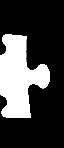

tensor([7.6851e-05, 9.9992e-01], device='cuda:0') tensor(1., dtype=torch.float64)


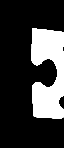

tensor([2.5592e-05, 9.9997e-01], device='cuda:0')


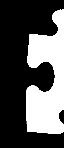

tensor([3.0024e-05, 9.9997e-01], device='cuda:0')


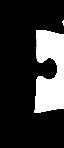

tensor([4.4922e-05, 9.9996e-01], device='cuda:0')


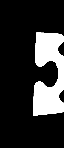

tensor([7.6851e-05, 9.9992e-01], device='cuda:0')


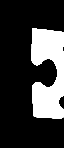

tensor([8.4154e-05, 9.9992e-01], device='cuda:0')


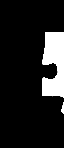

tensor([1.0120e-04, 9.9990e-01], device='cuda:0')


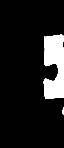

tensor([1.1616e-04, 9.9988e-01], device='cuda:0')


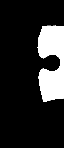

tensor([1.2418e-04, 9.9988e-01], device='cuda:0')


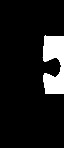

tensor([1.5449e-04, 9.9985e-01], device='cuda:0')


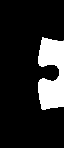

tensor([1.7059e-04, 9.9983e-01], device='cuda:0')


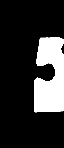

In [ ]:
from PIL import Image

pil_image = torchvision.transforms.ToPILImage()(img_compared)
pil_image.show()

print(preds[id], first_label)
pil_image = torchvision.transforms.ToPILImage()(pairs[id])
pil_image.show()

sorted_keys = sorted(top_5.keys(),reverse=True)
for i in sorted_keys[:10]:
  print(preds[top_5[i]])
  pil_image = torchvision.transforms.ToPILImage()(pairs[top_5[i]])
  pil_image.show()

### TOP_10 Evaluation

In [ ]:
preds = []
pairs = []
list_top_5 = []
with torch.no_grad():
  for id in range(len(dataset_test)):
    top_5 = {}
    img_compared = dataset_test.__getitem__(id)[0]
    img_compared = torch.Tensor.reshape(img_compared.to(device), (1,1,148,64))
    perfect_pair = dataset_test.__getitem__(id)[1].to(device)
    is_match = int(dataset_test.__getitem__(id)[2])

    if is_match:
      for i in range(len(dataset_test)):
        x = dataset_test.__getitem__(i)
        # pairs.append(x[1].to(device))

        second_img = torch.Tensor.reshape(x[1].to(device), (1,1,148,64))
        with torch.set_grad_enabled(False):
          outputs = model(img_compared, second_img)
          preds += outputs
          for output in outputs:
            if output[0]<output[1]:
              top_5[float(output[1])] = i
        
      list_top_5.append(top_5)
    else:
      list_top_5.append({})

In [ ]:
print(list_top_5[0])
test_df = pd.read_csv('/content/gdrive/MyDrive/puzzle_pieces/puzzle_pairs_test.csv')

In [ ]:
total=0
correct=0
for id in range(len(dataset_test)): 
  label = dataset_test.__getitem__(id)[2]
  # print(test_df.loc[id][0], test_df.loc[id][1], int(label), preds[id])
  if int(label) == 1:
    total += 1
    top_5_id = list_top_5[id]
    sorted_keys = sorted(top_5_id.keys(),reverse=True)
    for i in sorted_keys[:10]:
      # print(test_df.loc[top_5_id[i]][1], i)
      if test_df.loc[top_5_id[i]][1] == test_df.loc[id][1]:
        correct += 1
  # print("-------------------")
print(total, correct)

162 20


### Test on new images 

In [ ]:
model_path = "/content/gdrive/MyDrive/models/inverted_img_no_dropout.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path, device)

In [ ]:
preds=[]
with torch.no_grad():
  for id in range(1):
    img1 = Image.open("/content/v3.png").convert('L')
    w,h = 148,148
    img1 = transforms.functional.crop(img1,0,int(w/2)+10,h,int(w/2)-10) # top, left, height, width
    img1.show()
    img1 = transforms.Compose([
            transforms.ToTensor()
        ])(img1)
    img1_tensor = torch.Tensor.reshape(img1.to(device), (1,1,148,64))

    img2 = PIL.ImageOps.invert(Image.open("/content/v2.png").convert('L'))
    img2 = transforms.functional.crop(img2,0,0,h,int(w/2)-10)
    img2 = transforms.Compose([
            transforms.ToTensor()
        ])(img2)
    img2_tensor = torch.Tensor.reshape(img2.to(device), (1,1,148,64))
    

    with torch.set_grad_enabled(False):
      outputs = model(img1_tensor, img2_tensor)
      preds += outputs

In [ ]:
print(preds)

[tensor([0.4710, 0.5290], device='cuda:0')]
